# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [18]:

# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80


# sklearn modules
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.pipeline import make_pipeline           # combining classifier steps
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay


In [46]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d['flag_sc'] = d['flag_sc'].fillna('N')
d['rr_ind'] = d['rr_ind'].fillna('N')
d.drop(columns=['id_loan_rr', 'id_loan'])
d = d[d['fico'] != 9999] # removed missing credit scores for now but perhaps we should reconsider
d = d[d['mi_pct'] != 999]
d = d[d['cltv'] != 999]
d = d[d['property_val'] != 9]



/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
d.head()


,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,N,NaN,9,N,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,N,NaN,9,N,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,N,NaN,9,N,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,N,NaN,9,N,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",N,NaN,9,N,2,N,7,active


### Null Values

The data includes approximately 20,000 Null values for the **cd_msa** information. Despite this, there is no missing information on **zipcode**. **Fill in missing data**. **Comment on the number of defaulters in this subset of the data, suggesting that people who live outside MSAs are perhaps more likely to default on loans.**


The remaining features that contain null values are **flag_sc**, and **rr_ind**, however these are categorical variables that take NaN to refer to 'No'. All NaN entries have been replaced with 'N'.


### Missing Data

There are 41 missing Credit Scores in the dataset. Out of these, 3 loans were defaults. Since the dataset does not contain many defaults, we do not want to exclude this information. **How do we deal with this?** Only one observation is not available for the Mortgage Insurance Percentage and given this loan was not a default, we will exclude it from the data set. **Check if any other information in this observation might be important**. There are 6 missing observations for combined loan-to-value, and 2 of these are the missing values for loan-to-value, which occurs when the loanee has no other loans. None of these loans were defaults, so they have been excluded.

There are 2,412 missing values for the debt-to-income ratio, and more notably, a disproportinal number of these observations are loans that have defaulted. When debt-to-income ratio is greater than 65%, it is classified as a missing value. These are loans where the monthly debt payments are greater than 65% of monthly income of the loanee suggesting that they are higher-risk loans. **How do we deal with this?**

We interpret the value of 9 for the program indicator as Not Applicable meaning that the loan is not part of a program. There could be missing data embedded within this, however since this category acts as a baseline associated to no programs, then this assumption does not lose any information.

There are 125 values missing for property value. None of these are defaults, so they have been excluded.







### Imbalanced data

We do some first analysis of the categorical variables. We check visually and with value counts whether each feature is balanced across the data. This also identifies features that are constantly valued across the traingin data that we can discard for our analysis as they cannot have any meaningful interperetation in the model. Heavily imbalanced categorical data can also lead to problems when splitting the data for training and validation, as it can result in the test data containing entries not seen in the training data.

We will not consider active loans in the training because we are doing a classification task and there is no way to train our model on data without any output.

The categorical variables **ppmt_pnlty** and **io_ind** have the same value across the dataset and should be removed from consideration in any model. There are no prepayment penalty mortgages or finite-length mortgages in the dataset.

What is an acceptable level of imbalanace in the data? Should we combine any of the low-frequency data points as in e.g **cnt_borr**?


1    66000
2    59854
3      641
4       89
5        1
Name: cnt_borr, dtype: int64 1    124209
2      1688
3       367
4       321
Name: cnt_units, dtype: int64 SF    77757
PU    37490
CO    10807
MH      384
CP      147
Name: prop_type, dtype: int64


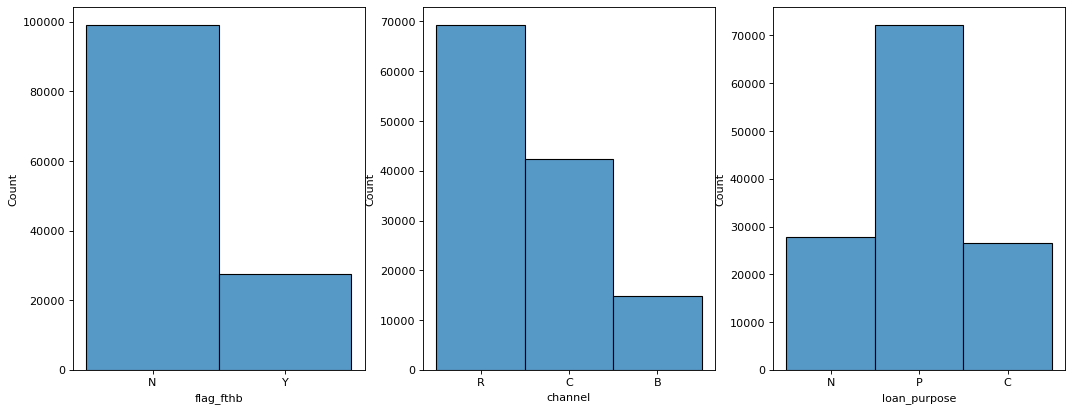

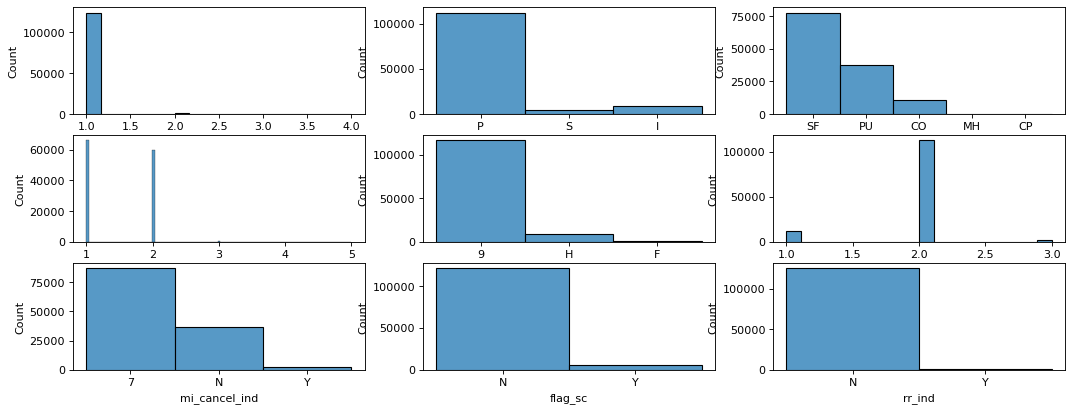

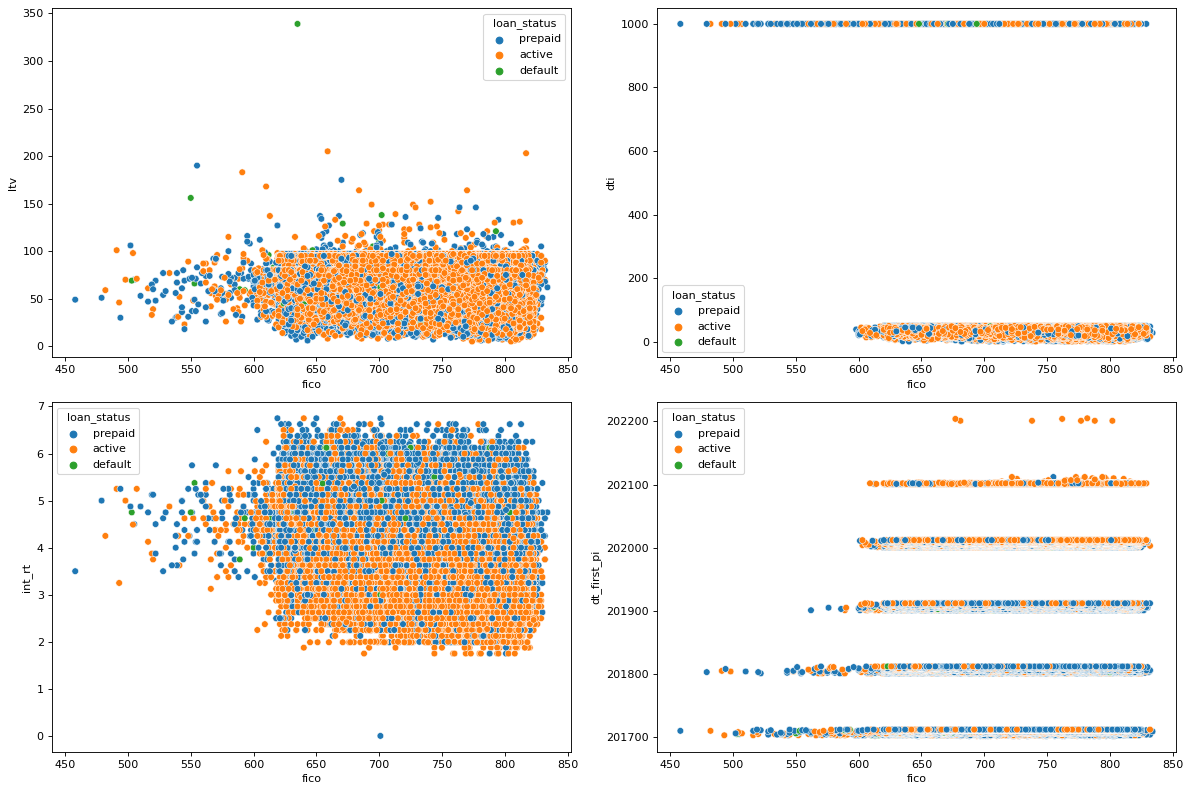

In [47]:
# We exclude active loans
df = d[d["loan_status"] != 'active']

#Visualisation of the spread of categorical variables 
output_var = ["loan_status"]
cat_var=["flag_fthb", "cnt_units", "occpy_sts", "channel", "ppmt_pnlty", "prop_type", "loan_purpose", "cnt_borr", "flag_sc", "program_ind", "rr_ind", "property_val", "io_ind", "mi_cancel_ind"]
locations =["cd_msa", "zipcode"]
loan_providers = ["seller_name", "servicer_name"]


unbalanced_cat_var = ["cnt_units", "occpy_sts", "prop_type", "cnt_borr", "program_ind", "property_val", "mi_cancel_ind", "flag_sc", "rr_ind"]
#Constant valued 
sing_val = ["ppmt_pnlty", "io_ind"]
balanced_cat_var =cat_var
for i in unbalanced_cat_var:
    balanced_cat_var.remove(i)
for i in sing_val:
    balanced_cat_var.remove(i)

fig, ax = plt.subplots(1,3, figsize = (16,6))

for i,var in enumerate(balanced_cat_var):
    sns.histplot(data=df, x= var, ax = ax[i])

fig, ax = plt.subplots(3,3, figsize = (16,6))

for i,var in enumerate(unbalanced_cat_var):
    sns.histplot(data=df, x= var, ax = ax[i//3, i%3])
    
print(df["cnt_borr"].value_counts(),df["cnt_units"].value_counts(),df["prop_type"].value_counts())

# Data visualisation

fig, axes = plt.subplots(ncols = 2, nrows=2, figsize=(15,10))

sns.scatterplot(data = d, x = "fico", y="ltv", hue="loan_status", ax=axes[0,0])
sns.scatterplot(data = d, x = "fico", y="dti", hue="loan_status", ax=axes[0,1])
sns.scatterplot(data = d, x = "fico", y="int_rt", hue = "loan_status", ax=axes[1,0])
sns.scatterplot(data = d, x = "fico", y="dt_first_pi", hue = "loan_status", ax=axes[1,1])
plt.tight_layout()
plt.show()


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

### Discretisation

We see that the numerical variable **dti** (debt-to-income ratio) is capped at 50%, and values above this are given the value 999, we cannot interperet this data linearly unless we first transform the data in some way. One way of transforming the data is to discretise it and give it an ordinal encoding. To find the optimal encoding we use the stratified K-folds cross-validation method on KBinsDiscretizer in the baseline logistic regression model to decide the number of bins. This gives us an optimal parameter of 10 bins. This also allows the possibility of introducing an interaction term for the capped data. 

best param:  {'pre_processing__disc__n_bins': 10}


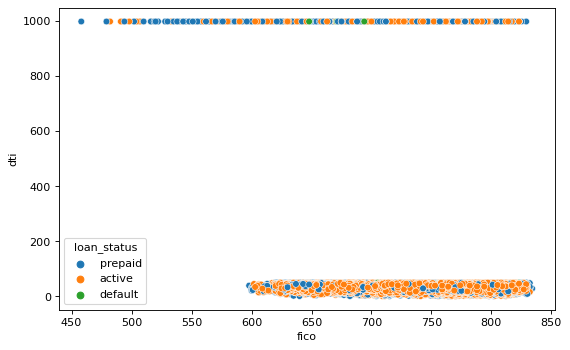

In [54]:
#Scatter plot showing the problematic distribution in this category
disc = ColumnTransformer(
        [("disc",  KBinsDiscretizer(n_bins=10, encode='ordinal'),[dti_loc])])
d_disc  = disc.fit_transform(df)
sns.scatterplot(data = d, x = "fico", y="dti", hue="loan_status")

# Feature matrix and response vector
X, y = df.drop(["loan_status"], axis=1), df["loan_status"]
X = X.values

# Binary encoding of response vector
y = LabelEncoder().fit_transform(y)

# Stratified split of test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, stratify=y,
                                                    test_size = 0.1, random_state=212)

# Get the index of all the variables included in the baseline model
dti_index = d.columns.get_loc("dti")
#No longer including ltv
num_var = ["fico","dt_first_pi","mi_pct","orig_upb","int_rt","dt_matr","cltv","orig_loan_term"]
cat_var=["seller_name", "servicer_name","flag_fthb", "cnt_units", "occpy_sts", "channel", "prop_type", "loan_purpose", "cnt_borr", "flag_sc", "program_ind", "rr_ind", "property_val", "mi_cancel_ind"]
num_var_index = []
for i in num_var:
    num_var_index.append(d.columns.get_loc(i))
cat_var_index = []
for i in cat_var:
    cat_var_index.append(d.columns.get_loc(i))

# Pipeline
log_pipe = Pipeline(
    [("pre_processing", ColumnTransformer(
        [("disc", KBinsDiscretizer(encode='ordinal'), [dti_index]),
         ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), cat_var_index),
         ("num", StandardScaler(), num_var_index)]
    )),
    ("model", LogisticRegression(random_state=42, penalty=None))]
)

parameters = {
   'pre_processing__disc__n_bins': np.arange(2,16,1)
}

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=1001)
#grid_search = GridSearchCV(log_pipe, parameters, cv = kf, scoring = 'f1', return_train_score=True).fit(X_train, y_train)

print("best param: ", grid_search.best_params_)



# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

### Baseline logistic regression model 

First attempt: model using only credit score and 2 categorical variables gives no true positives.

Second attempt: model using most numerical and categorical variables now gives some true positives and has an AUC score of 0.84

Third attempt: model using same features with discretised **dti** has an AUC score of 0.85, so some improvement

[23, 24, 2, 6, 7, 13, 17, 20, 22, 25, 27, 28, 29, 31]


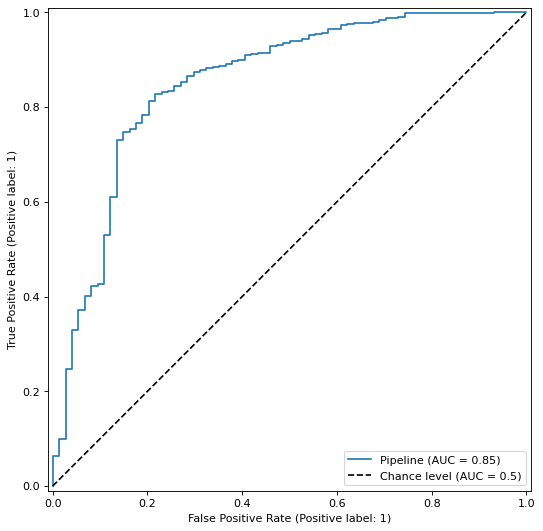

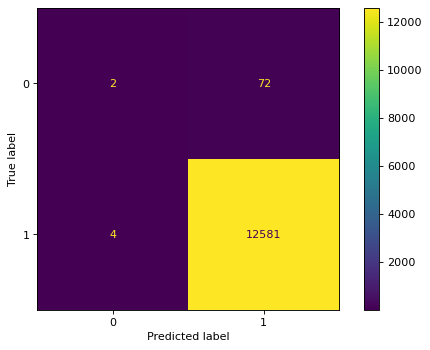

AUC: 0.8526688786521921


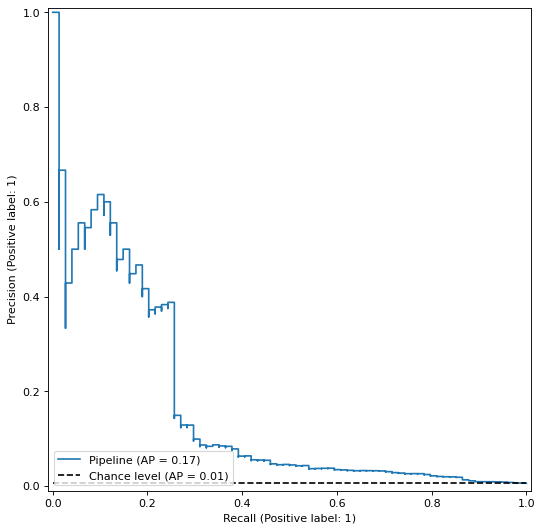

In [ ]:
# Feature matrix and response vector
X, y = df.drop(["loan_status"], axis=1), df["loan_status"]

# Convert to numpy array
X = X.values

# Binary encoding of response vector
y = LabelEncoder().fit_transform(y)

# Stratify split of test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, stratify=y,
                                                    test_size = 0.1, random_state=212)

# Get the index of the variables we will include
dti_loc = d.columns.get_loc("dti")
#No longer including ltv
num_var = ["fico","mi_pct","orig_upb","int_rt","cltv","orig_loan_term"]
num_var_index = []
for i in num_var:
    num_var_index.append(d.columns.get_loc(i))

cat_var=["seller_name", "servicer_name","flag_fthb", "cnt_units", "occpy_sts", "channel", "prop_type", "loan_purpose", "cnt_borr", "flag_sc", "program_ind", "rr_ind", "property_val", "mi_cancel_ind"]
cat_var_index = []
for i in cat_var:
    cat_var_index.append(d.columns.get_loc(i))

# Pipeline
log_pipe = Pipeline(
    [("pre_processing", ColumnTransformer(
        [("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), cat_var_index),
         ("disc", KBinsDiscretizer(n_bins =10,encode='ordinal'), [dti_loc]),
         ("num", StandardScaler(), num_var_index)]
    )),
    ("model", LogisticRegression(random_state=42, penalty=None))]
)
# Fit the model using the training data
model = log_pipe.fit(X_train, y_train)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(log_pipe, X_test, y_test,plot_chance_level=True, ax = ax)
plt.show()

ConfusionMatrixDisplay.from_estimator(log_pipe, X_test, y_test)
plt.show()

# Compute the probabilities for each class on the test data (N_test by C matrix)
y_test_prob = log_pipe.predict_proba(X_test)

# Compute the AUC
print('AUC:', roc_auc_score(y_test, y_test_prob[:,1]))

y_train_inverted = 1 - y_train
y_test_inverted = 1 - y_test

# Refit the model with inverted labels
model_inverted = log_pipe.fit(X_train, y_train_inverted)

# Plot the precision-recall curve with inverted labels
fig, ax = plt.subplots(figsize=(8,8))
PrecisionRecallDisplay.from_estimator(log_pipe, X_test, y_test_inverted, plot_chance_level=True, ax=ax)
plt.show()

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [7]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] Support files will be in project2_files/
[NbConvertApp] Making directory ./project2_files
[NbConvertApp] Making directory ./project2_files
[NbConvertApp] Making directory ./project2_files
[NbConvertApp] Writing 69469 bytes to notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/Users/oscaryoungman/opt/anaconda3/bin/jupyter-nbconvert", line 11, in <module>
    sys.exit(main())
  File "/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/jupyter_core/application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/Users/oscaryoungman/opt/anaconda3/lib/python3.9/site-packages/nbconvert/nbconvertapp.py", line 346, in start
    self.convert_notebooks()
  File "/Users/osca